In [1]:
from pathlib import Path

In [2]:
import sys
sys.path.append("/home/kl5675/Documents/22/git_sync/hpo/scripts")

In [3]:
from tune_02_perfect_ec import DynamicTCNTrainable

/home/kl5675/Documents/22/git_sync/wandb-offline-sync-hook/src/wandb_osh/ray_hooks.py:7: DeprecationWarning: The module `ray.tune.trial` has been moved to `ray.tune.experiment.trial` and the old location will be deprecated soon. Please adjust your imports to point to the new location. Example: Do a global search and replace `ray.tune.trial` with `ray.tune.experiment.trial`.
  from ray.tune.trial import Trial


In [4]:
# ray_dir = Path("~").expanduser() / "ray_results"
# assert ray_dir.is_dir()

# group_name = "tcn-perfect"

# ray_group_dir = ray_dir / group_name
# assert ray_group_dir.is_dir()

# experiment_name = "DynamicTCNTrainable_44ec0e7e_11_attr_pt_thld=0.5522,batch_size=1,gnn_tracking_experiments_hash=ef12903a6f862a36bedcd8b90da61ad0d39_2022-12-02_11-32-43"

In [5]:
def find_checkpoints(project: str, part: str, base_path = Path("~/ray_results/").expanduser() ):
    project_dir = base_path / project
    hits = [d for d in project_dir.iterdir() if d.is_dir and part in d.name]
    if len(hits) == 0:
        raise ValueError("No such directory found")
    if len(hits) >= 2:
        raise ValueError("Non-unique description of dir")
    result_dir = hits[0]
    assert result_dir.is_dir()
    checkpoints = sorted(result_dir.glob("checkpoint_*"))
    if not checkpoints:
        raise ValueError(f"No checkpoints at {result_dir}")
    checkpoint_files = [cp / "checkpoint.pt" for cp in checkpoints]
    assert all(cpf for cpf in checkpoint_files)
    return checkpoint_files

In [6]:
checkpoint_path = find_checkpoints("tcn-perfect-s9", "50ab9d5e")[-1]

In [7]:
params_file = checkpoint_path.parent.parent / "params.json"
assert params_file.is_file()

In [8]:
import json

In [9]:
config = json.loads(params_file.read_text())

In [10]:
config.update({"n_graphs_train": 1, "n_graphs_val": 100, "n_graphs_test": 1})

In [11]:
trainable = DynamicTCNTrainable(config)

DEBUG: Got config
{'attr_pt_thld': 0.08228415402956779,
 'batch_size': 1,
 'gnn_tracking_experiments_hash': '8457a96f9bf9a1a475525377b3c4fc1546177d40',
 'gnn_tracking_hash': 'cb5dbf4e9497765f596435ab1f78955fcc880b41',
 'lr': 0.0004624177499399337,
 'm_L_hc': 3,
 'm_alpha_hc': 0.4095578889389337,
 'm_e_dim': 5,
 'm_ec_tnr': 1.0,
 'm_ec_tpr': 1.0,
 'm_h_dim': 6,
 'm_h_outdim': 3,
 'm_hidden_dim': 116,
 'n_graphs_test': 1,
 'n_graphs_train': 1,
 'n_graphs_val': 100,
 'optimizer': 'adam',
 'q_min': 0.4226749345603287,
 'rlw_background': 1.0,
 'rlw_potential_attractive': 1.0,
 'rlw_potential_repulsive': 2.643668569195838,
 'sb': 0.13294156029135204,
 'scheduler': None,
 'sector': 9,
 'test': False}
INFO: Loading data to cpu memory
INFO: Loading 102 graphs (out of 371 available).
DEBUG: Parameters for data loaders: {'batch_size': 1, 'num_workers': 12}
/scratch/gpfs/kl5675/miniconda3/envs/gnn/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will cr

In [12]:
trainable.load_checkpoint(checkpoint_path, device="cpu")

In [13]:
import torch

In [102]:
trainer = trainable.trainer
trainer.model.eval()

sel = 20
with torch.no_grad():
    loader = trainer.val_loader
    for idx, data in enumerate(loader):
        if idx < sel:
            continue
        model_output = trainer.evaluate_model(data, mask_pids_reco=False)
        if idx == sel:
            break
        
        
x = model_output["x"]
pid = model_output["particle_id"]
pt = model_output["pt"]

In [103]:
len(set(data.particle_id)), len(set(pid))

(2285, 2285)

In [ ]:
len(mod)

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from gnn_tracking.plotting.latent import plot_coordinates_3d, plot_coordinates_flat, plot_selected_pids

<IPython.core.display.Javascript object>


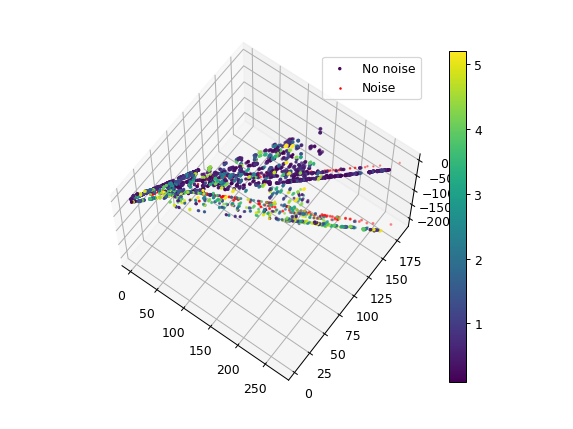

<Axes3DSubplot: >

In [19]:
%matplotlib notebook
plot_coordinates_3d(x, pid)

<AxesSubplot: title={'center': 'Color is third dimension'}>

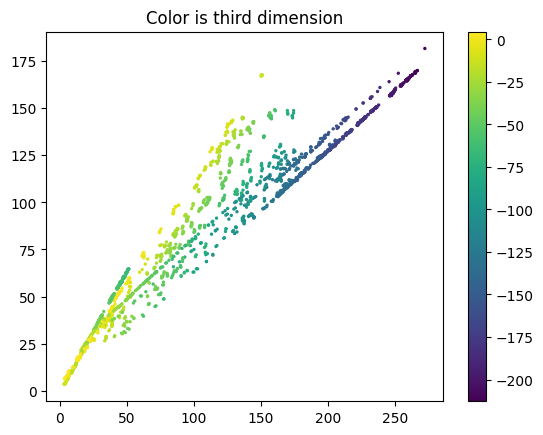

In [44]:
%matplotlib inline
plot_coordinates_flat(x)

In [152]:
plot_all_coordinates(x)

In [21]:
# plt.scatter(x[pid > 0][:, 0], x[pid > 0][:, 1], c="black", label="No noise")
# plt.scatter(x[pid <= 0][:, 0], x[pid <= 0][:, 1], c="red", label="Noise")
# plt.legend()

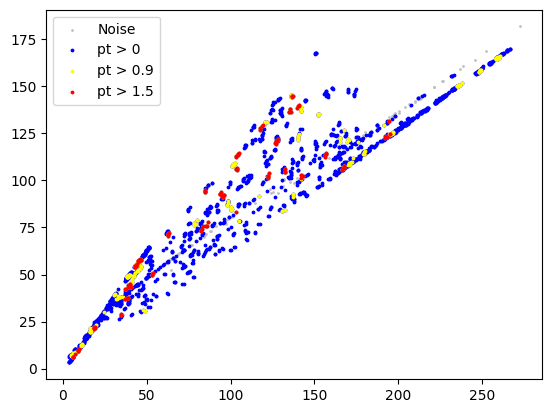

In [26]:
%matplotlib inline

plt.scatter(x[pid <= 0][:, 0], x[pid <= 0][:, 1], c="silver", label="Noise", s=1)
mask = pid > 0
# todo: not elegant, because we plot on top of each other
pt_thld_to_color = {
    0: "blue",
    0.9: "yellow",
    1.5: "red"
}
for thld, c in pt_thld_to_color.items():
    mask &= pt > thld
    plt.scatter(x[mask][:, 0], x[mask][:, 1], c=c, s=3, label=f"pt > {thld}")
plt.legend()

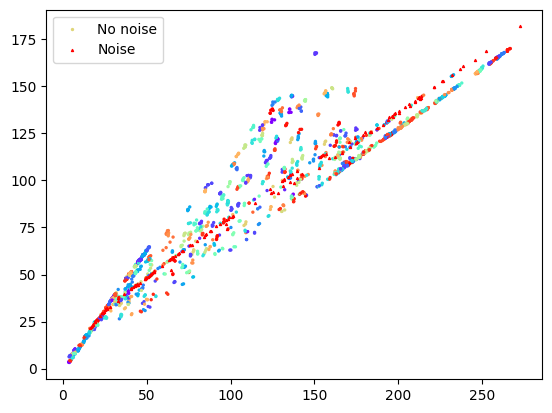

In [29]:
cax = plt.scatter(x[pid > 0][:, 0], x[pid > 0][:, 1], c=pid[pid > 0], label="No noise", s=2,  cmap="rainbow")
plt.scatter(x[pid <= 0][:, 0], x[pid <= 0][:, 1], c="red", label="Noise", s=2, marker="^")
plt.legend()

In [30]:
import pandas as pd
_, c = np.unique(selected_pids, return_inverse=True)

In [33]:
len(selected_pids)

15

In [32]:
len(c)

15

In [49]:
%matplotlib notebook

In [105]:

def plot_selected_pids(
    x: np.ndarray,
    pid: np.ndarray,
    selected_pids: Sequence[int] | None = None,
    *,
    ax: plt.Axes | None = None,
) -> plt.Axes:
    """Draw latent space, highlighting 10 randomly selected PIDs. In addition, shaded
    circles of radius 1 are drawn around each hit for the selected PIDs.

    Args:
        x: Coordinates in latent space. Only the first two coordinates are considered.
        pid:
        selected_pids: PIDs to highlight. If None, random PIDs are used
        ax:

    Returns:

    """
    c

    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()

    
    
    
    fig.legend()
    return ax


In [38]:
from gnn_tracking.utils.colors import lighten_color

In [127]:
class SelectedPidsPlot:
    def __init__(self, x_latent: np.ndarray, pid: np.ndarray, selected_pids: Sequence[int] | None = None,
                data: np.ndarray|None=None, 
                ):
        self.data = data
        self.x = x_latent
        self.pid = pid
        if selected_pids is None:
            selected_pids = np.random.choice(pid[pid > 0], 10).astype("int64")
        else:
            if len(selected_pids) > 10:
                raise ValueError("Only up to 10 PIDs can be specified.")
        self.selected_pids = selected_pids
    
        colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
        self._color_mapper = np.vectorize(colors.__getitem__)
        self._pid_mapper = np.vectorize({p.item(): i for i, p in enumerate(self.selected_pids)}.get)
    
    @staticmethod
    def plot_circles(ax: plt.Axes, xs: np.ndarray, ys: np.ndarray, colors, eps=1) -> None:
        assert xs.shape == ys.shape
        for x, y, c in zip(xs, ys, colors):
            circle = plt.Circle(
                (x, y), eps, facecolor=lighten_color(c, 0.2), linestyle="none"
            )
            ax.add_patch(circle)
    
    def get_colors(self, pids):
        return self._color_mapper(self._pid_mapper(pids))
    
    def plot_selected_pid_latent(self, ax):
        # todo: mark condensation point
        mask = np.isin(self.pid, self.selected_pids)
        c = self.get_colors(self.pid[mask])
        self.plot_circles(ax, self.x[mask][:, 0], self.x[mask][:, 1], c)
        ax.scatter(self.x[mask][:, 0], self.x[mask][:, 1], c=c, label="Hits of selected PIDs", s=2)
    
#     def get_conflic
    
    def plot_other_hit_latent(self, ax):
        mask = np.isin(pid, self.selected_pids)
        ax.scatter(
            self.x[~mask][:, 0], x[~mask][:, 1], c="silver", alpha=1, label="Other hits", s=2
        )
    
    def plot_selected_pid_ep(self, ax):
        assert self.data is not None
        mask = np.isin(self.data.particle_id, self.selected_pids)
        ax.scatter(
            self.data.x[:, 3][mask],
            self.data.x[:, 1][mask],
            c=self.get_colors(self.data.particle_id[mask]),
            s=2
        )
    
    def plot_other_hit_ep(self, ax):
        assert self.data is not None
        mask = ~np.isin(self.data.particle_id, self.selected_pids)
        ax.scatter(
            self.data.x[:, 3][mask],
            self.data.x[:, 1][mask],
            c="silver",
            s=2
        )

<IPython.core.display.Javascript object>


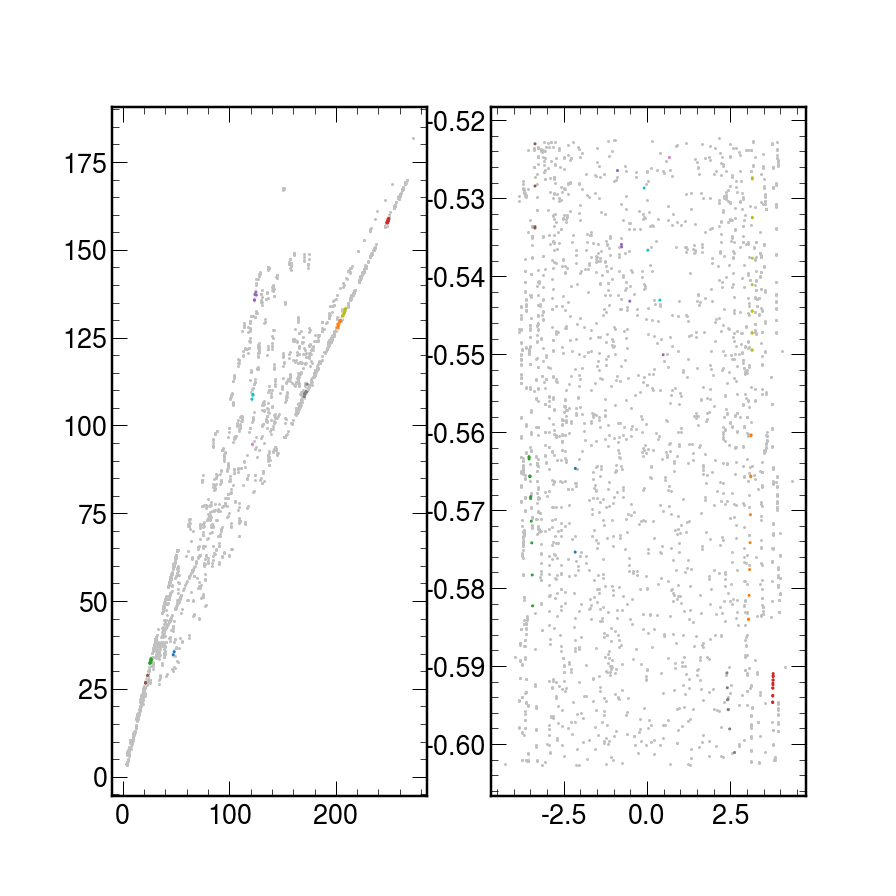

In [128]:
%matplotlib notebook
spp = SelectedPidsPlot(x, pid, data=data)
fig, axs = plt.subplots(ncols=2)
spp.plot_other_hit_latent(axs[0])
spp.plot_selected_pid_latent(axs[0])
spp.plot_other_hit_ep(axs[1])
spp.plot_selected_pid_ep(axs[1])


<IPython.core.display.Javascript object>


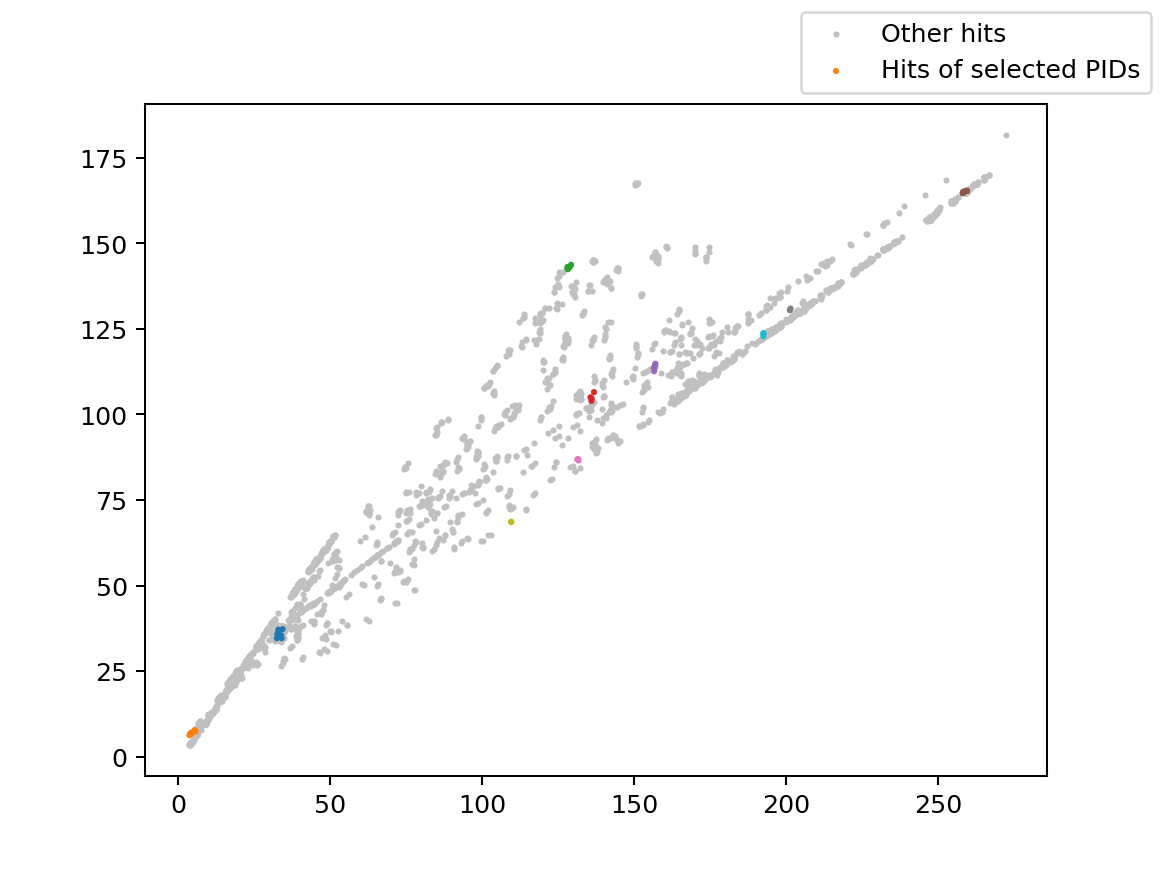

<AxesSubplot: >

In [49]:
%matplotlib notebook
plot_selected_pids(x, pid)


In [32]:
data.x.shape

torch.Size([2149, 6])

In [22]:
graph_plotter = GraphPlotter()

y
z
a


KeyboardInterrupt: 

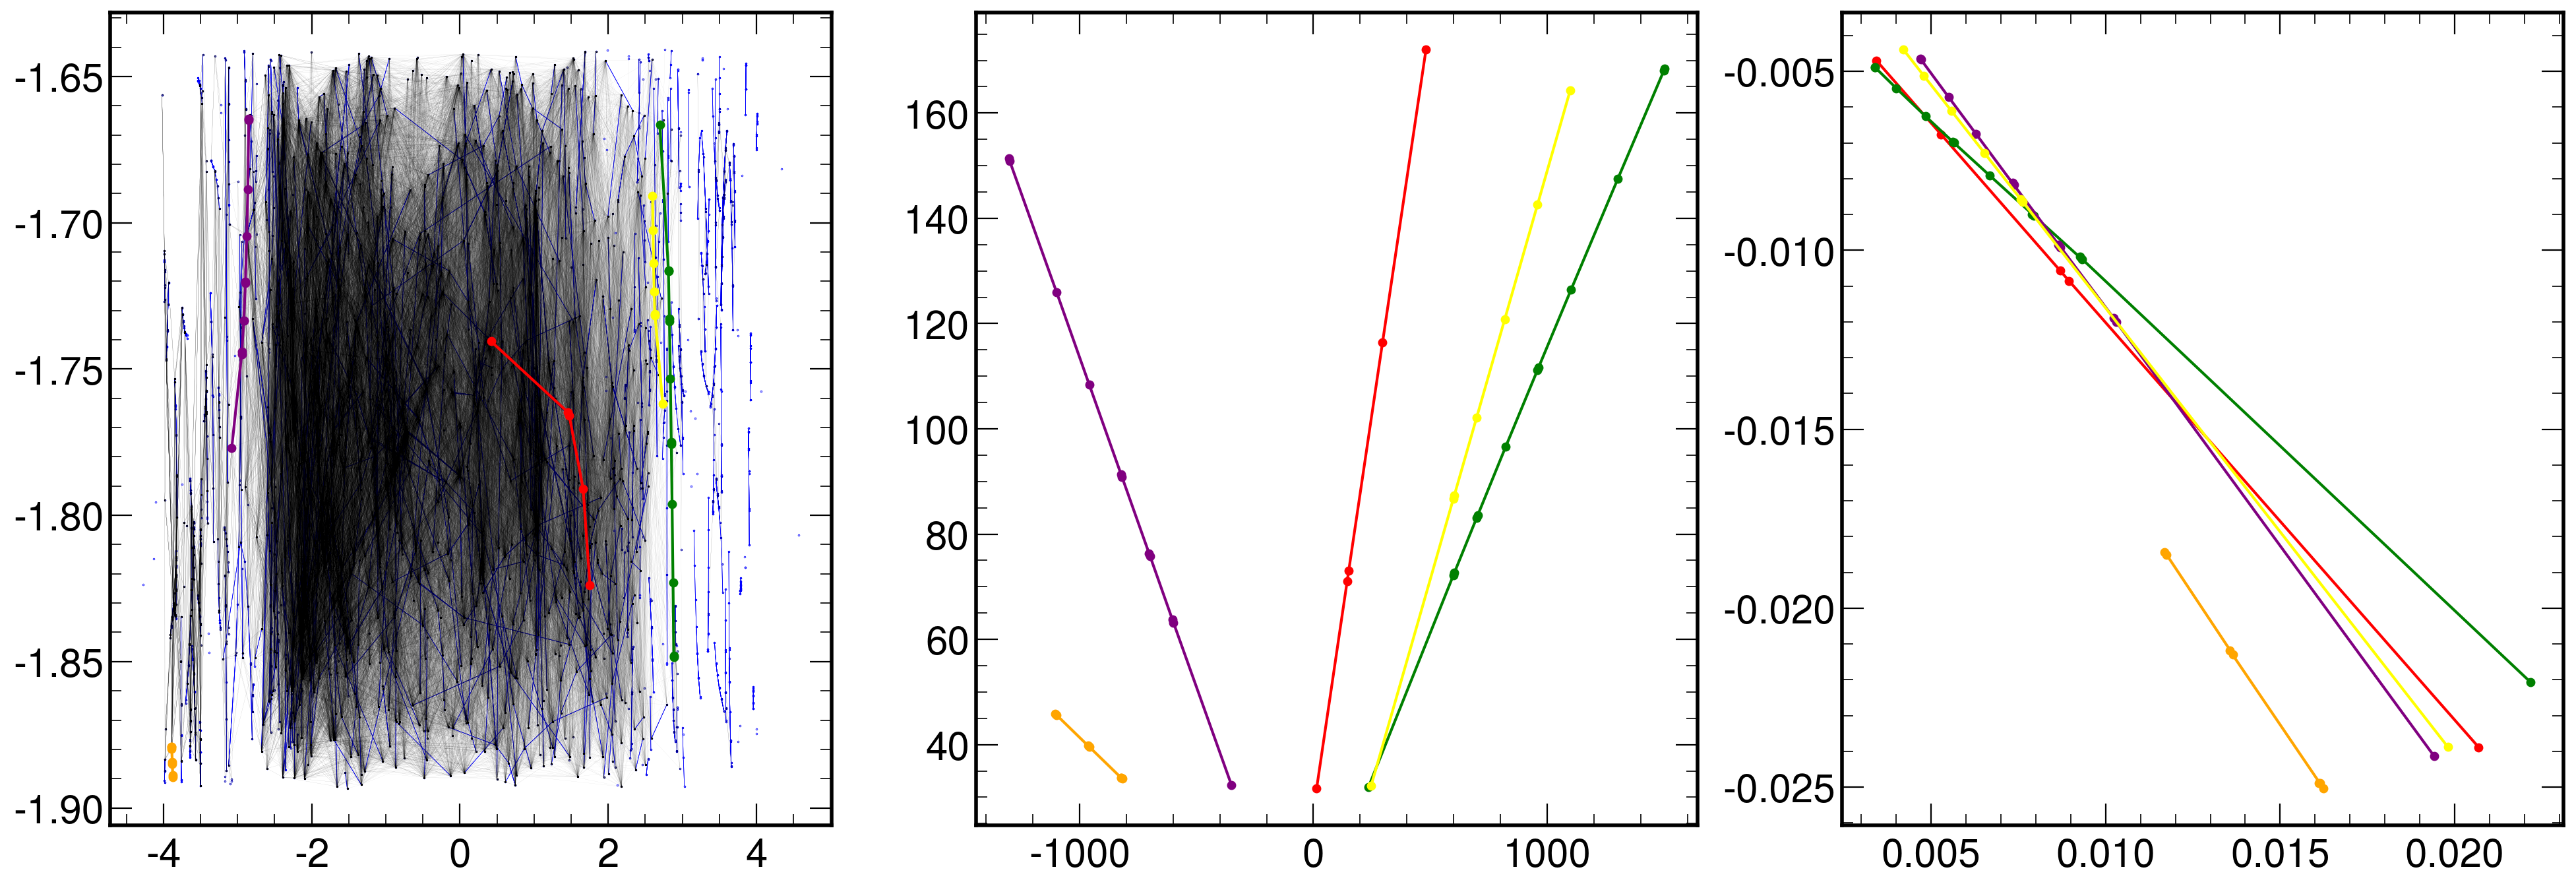

In [23]:
graph_plotter.plot_ep_rz_uv(data, sector=9, name="test")